# Selección y rendimiento del clasificador

En este cuaderno vamos a realizar un proyecto completo de ML, salvo por la fase de Test.<br>
Respecto de cuadernos anteriores, aprenderemos a:
+ integrar la validación cruzada en el entrenamiento y la validación
+ evaluar el rendimiento de un modelo con la matriz de confusión y la curva ROC
+ elegir un modelo entre varios.

---
    [ES] Código de Alfredo Cuesta Infante para 'Reconocimiento de Patrones'
       @ Master Universitario en Visión Artificial, 2020, URJC (España)
    [EN] Code by Alfredo Cuesta-Infante for 'Pattern Recognition'
       @ Master of Computer Vision, 2020, URJC (Spain)

    alfredo.cuesta@urjc.es

### Preliminares 

En la siguiente celda se realizan los siguientes pasos:
1. carga de módulos genéricos
2. leer los datos y cargarlos en dataframes
2. extracción de características

In [1]:
#-[1]. Load data from CSV and put all in a single dataframe 'FullSet'

import numpy  as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
sys.path.append('../../MyUtils/')
import MyUtils as my
seed = 1234 #<- random generator seed (comment to get randomness)

#-[2]. Load data from CSV and put all in a single dataframe 'FullSet'

FullSet_0 = pd.read_csv('../../Datasets/1000ceros.csv', header=None)
FullSet_1 = pd.read_csv('../../Datasets/1000unos.csv',  header=None)
FullSet = my.join_features_labels(FullSet_0,FullSet_1)

#-[3]. Convert the 'FullSet' of pixels into the set 'X_full' of features and get the set 'Y_full' of labels

theta = 0.5
X_full = my.mnist_features( FullSet.drop('label', axis=1), theta=theta )
Y_full = FullSet[['label']]

## Novedades

4. Añadimos un K-fold estratificado para hacer varias ejecuciones.
5. Realizamos el reescalado y aprendizaje del clasificador para cada *fold*

In [2]:
#-[4]. Split X_full into TRAIN and TEST with Stratified K-Fold 

from sklearn.model_selection import StratifiedKFold

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)
skf_ix = skf.split(X_full,Y_full)  

train_ix_list=[] #<- :outcome: list of indexes for training
valid_ix_list=[] #<- :outcome: list of indexes for validation

# skf_ix is a generator
# I'm going to convert it into an iterator (a list)
for train_ix, valid_ix in skf_ix:
    train_ix_list.append(train_ix)
    valid_ix_list.append(valid_ix)

    
#-[5]. For-loop that scales to [0,1] the training subsets and trains

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import  LogisticRegression

scaler = MinMaxScaler()
clf = LogisticRegression()

count = 0        #<- just for tracking 

scaler_list=[]   #<- :outcome: list of scalers
clf_list=[]      #<- :outcome: list with the classfiers fitted

for train_ix in train_ix_list:

    #--extract and scale X and y
    X = scaler.fit_transform(X_full.iloc[train_ix])
    y = Y_full.iloc[train_ix].values.ravel()
    scaler_list.append(scaler)
    
    #--train the classifier and append it to the list
    clf.fit(X,y)
    clf_list.append(clf)
    
    count+=1    

6. Probar cada clasificador con el fold reservado para validación, que debe ser reescalado

Fold 0: HITS = 364, FAILS = 36
AUROC = 0.97
Fold 1: HITS = 367, FAILS = 33
AUROC = 0.98
Fold 2: HITS = 370, FAILS = 30
AUROC = 0.98
Fold 3: HITS = 375, FAILS = 25
AUROC = 0.98
Fold 4: HITS = 357, FAILS = 43
AUROC = 0.96


(0.0, 0.5, 0.5, 1.0)

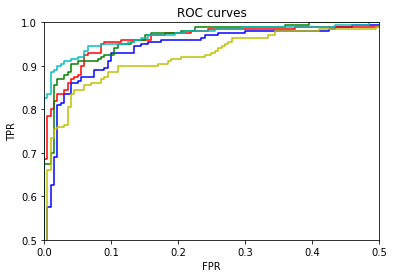

In [3]:
#-[6]. For-loop that scales to [0,1] the test subsets and evaluates the performance

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

count = 0  #<- just for tracking

hits_list=[]  #<- :outcome: list of hits
auroc_list=[] #<- :outcome: list of area under ROCs

for valid_ix, scaler, clf in zip(valid_ix_list, scaler_list, clf_list):
    
    #--scale the fold held-out for validation
    X_test = scaler.transform(X_full.iloc[valid_ix])
    y_test = Y_full.iloc[valid_ix].values.ravel()
    
    #--predict the validation fold
    y_pred = clf.predict(X_test)       #<- for confusion_matrix
    y_prob = clf.predict_proba(X_test) #<- for ROC curves
    
    #--print out the hits and fails of each fold
    conf_mat = confusion_matrix(y_test, y_pred)
    hits = conf_mat[0,0]+conf_mat[1,1]
    fails = conf_mat[0,1]+conf_mat[1,0]
    hits_list.append(hits)
    strlog = "Fold %d: HITS = %d, FAILS = %d" %(count, hits , fails )
    print(strlog)
    
    #--ROC curves
    color_list='brgcy'
    fpr, tpr, thresholds = roc_curve(y_test,y_prob[:,1])
    # Notice that y_prob contains:
    #  the probability of class 0 in the column #0
    #  the probability of class 1 in the column #1
    # So we use column #1 as predictor
    plt.plot(fpr,tpr,color_list[count])
    plt.title("ROC curves"); plt.xlabel("FPR"); plt.ylabel("TPR")
    # you can also try: metrics.plot_roc_curve(clf, X_test, y_test)
    
    #--AUROC
    auroc = roc_auc_score(y_test, y_prob[:,1])
    auroc_list.append(auroc)
    strlog = "AUROC = %0.2f" %auroc
    print(strlog)
    
    count+=1    

plt.axis([0,0.5, 0.5,1]) #<- zoom into the upper-left quarter of the ROC

In [4]:
#-[7]. Select the model

listMean = lambda x : sum(x)/len(x)
hits_mean =  listMean(hits_list)
model_ix = np.argmin( abs(hits_list - hits_mean) ) 

model = clf_list[model_ix] #<--MY CHOICE !

logstr = "Pick model #%d" %model_ix
print(logstr)

model.__dict__

Pick model #1


{'penalty': 'l2',
 'dual': False,
 'tol': 0.0001,
 'C': 1.0,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'class_weight': None,
 'random_state': None,
 'solver': 'lbfgs',
 'max_iter': 100,
 'multi_class': 'auto',
 'verbose': 0,
 'warm_start': False,
 'n_jobs': None,
 'l1_ratio': None,
 'n_features_in_': 10,
 'classes_': array([0., 1.]),
 'coef_': array([[-7.30562933,  0.01481984, -0.3544574 ,  0.48263306,  4.1095241 ,
          0.47026533, -0.05525042, -0.92398144, -4.46806801, -0.56135904]]),
 'intercept_': array([2.93697896]),
 'n_iter_': array([26], dtype=int32)}

## Ejercicio

1. Empaquetar en funciones los bloques 4, 5 y 6
2. Modificar el código para realizar un proyecto ML completo que incluya probar con un conjunto de Test que sea el 10% del conjunto de datos dado.

### Solucion